In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import numpyro
except ImportError:
    %pip uninstall -y jax jaxlib
    %pip install -q numpyro jax jaxlib

try:
    import arviz
except ImportError:
    %pip install arviz

(classification)=

## GP Classification

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [3]:
numpyro.set_host_device_count(2)

In [4]:
import numpyro
import numpyro.distributions as dist

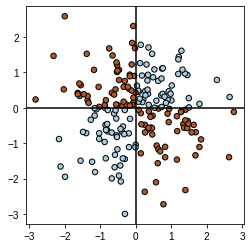

In [5]:
X = jax.random.normal(jax.random.PRNGKey(1234), (200, 2))
y = jnp.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(
    X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0)
)
plt.gca().set_aspect("equal")
_ = plt.axhline(0, color="k")
_ = plt.axvline(0, color="k")

In [6]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T
T = jnp.vstack((xx.ravel(), yy.ravel())).T

In [7]:
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

In [8]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, transforms, GaussianProcess

jax.config.update("jax_enable_x64", True)

outer_kernel = None
outer_mean = None

def model(x, y = None):
    # Set up a typical Squared Exponential kernel
    mean = numpyro.param("mean", jnp.zeros(()))
    sigma = numpyro.param("sigma", jnp.ones(()))
    ell = numpyro.param("ell", jnp.ones(()))

    kernel = (sigma ** 2) * kernels.ExpSquared(scale = ell)

    gp = GaussianProcess(kernel, x, diag=1e-5, mean = mean)

    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    l = sigmoid(log_rate)
    numpyro.sample("obs", dist.Bernoulli(probs = l), obs = y)


nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(55873)
mcmc.run(rng_key, X, y=y)
samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
q = np.percentile(samples["log_rate"], [5, 25, 50, 75, 95], axis=0)

In [16]:
y_hat = sigmoid(q[2]) > 0.5

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 96.00%


We see that our model did a reasonable job and got a good accuracy on the train data. Let us now visualize the predictions over a 2d grid.

In [22]:
q.shape

(5, 200)

In [17]:
outer_kernel

Product(kernel1=Constant(value=DeviceArray(1., dtype=float64)), kernel2=ExpSquared(scale=DeviceArray(1., dtype=float64), distance=L2Distance()))

In [15]:
nuts_kernel.model(T)

AssertionError: 

In [11]:
gp2 = GaussianProcess(nuy, X, diag = 1e-5, mean = outer_mean)

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with shape () and dtype float64 to escape.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was _single_chain_mcmc at /home/sachin.yadav/miniconda3/envs/sachin_env/lib/python3.9/site-packages/numpyro/infer/mcmc.py:384 traced for pmap.
------------------------------
The leaked intermediate value was created on line /tmp/ipykernel_2589675/3039996688.py:17 (model). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/home/sachin.yadav/miniconda3/envs/sachin_env/lib/python3.9/site-packages/numpyro/handlers.py:171 (get_trace)
/home/sachin.yadav/miniconda3/envs/sachin_env/lib/python3.9/site-packages/numpyro/primitives.py:105 (__call__)
/home/sachin.yadav/miniconda3/envs/sachin_env/lib/python3.9/site-packages/numpyro/primitives.py:105 (__call__)
/home/sachin.yadav/miniconda3/envs/sachin_env/lib/python3.9/site-packages/numpyro/primitives.py:105 (__call__)
/tmp/ipykernel_2589675/3039996688.py:17 (model)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [20]:
model

AttributeError: 'function' object has no attribute 'gp'

In [18]:
X.shape, T.shape

((200, 2), (10000, 2))

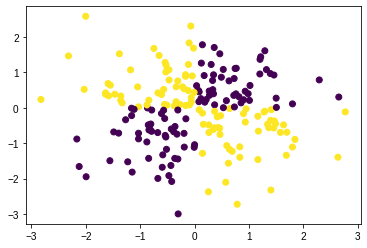

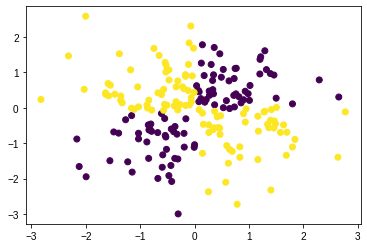

In [11]:
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y_hat)


In [24]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

# In newer version we should uncomment the following line
# xx, yy = jnp.meshgrid(xs, ys, indexing="xy")

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T


In [26]:
mean, var = jnp.exp(q[2]), jnp.exp(q[1])
Z = numpyro.sample("y_hat", dist.Bernoulli(sigmoid(mean)), rng_key = jax.random.PRNGKey(873))

In [27]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (200,) and (100, 100)

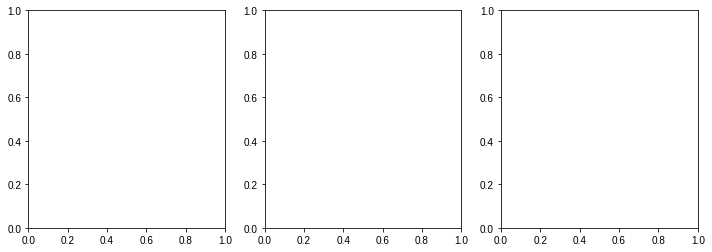

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(mean.reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    sigmoid(mean).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(T, xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()